<h1>E-Commerce Actual Data Transactions from UK Retailer</h1>
<br>
In this notebook we are going to explore an <a href='https://archive.ics.uci.edu/ml/datasets/Online+Retail'>e-commerce dataset transactions from an UK retailer</a>, this dataset lists purchases made by approximately 40000 customers through a period of time of one year <i>(from 12/01/2010 to 12/09/2011)</i>. The main aim of this notebook is to develop a machine learning model that allows to anticipate the purhcases that will be made by a new customer, over the next year according to its firsts purchases.
<br>
<br>
This notebooks is divided by the following steps:
<ul>
    <li>Data Cleaning.</li>
    <li>Feature Exploration.</li>
    <li>Understanding Product Categories.</li>
    <li>Customers Categories.</li>
    <li>Classifying Customers.</li>
    <li>Testing Predictions.</li>
    <li>Explaining The Decissions of The Model.</li>
</ul>

<h2>Importing Necessary Packages, Modules and Libraries</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

c:\users\kleye\anaconda3\envs\ai\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<h2>Data Cleaning</h2>
<br>
Let's load the dataset into memory! with <code>encoding</code> parameter and the value of <code>ISO-8859-1</code> will allows us to be able to read the dataset, for a better understanding of this parameter and its value, check the next links:
<ul>
    <li><code>encoding</code>: <a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html'>Pandas official docs for <code>read_csv</a> method.</li>
    <li><code>ISO-8859-1</code>: <a href=''>Codec registry and base classes</a>.</li>
</ul>
with <code>dtype</code> parameter by using a dictionary we convert into <code>string</code> variables the columns <code>CustomerID</code> and <code>InvoiceID</code>.

In [2]:
df = pd.read_csv('ecommerce-data/data.csv', encoding='ISO-8859-1', dtype={'CustomerID': str, 'InvoiceID': str})

Now with the data in memory, let's take a look a its dimensions.

In [3]:
df.shape

(541909, 8)

<b>541909</b> rows and <b>8</b> columns! Let's see general information of this dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


Looks like there are null values, missing values. We must clean up this dataset!
<br>
<br>
Let's create a variable <code>columns_info</code> that will hold the data types of every column in the dataset. This is done by creating a <code>DataFrame</code> object that has information the types of the columns that the dataset <code>df</code> holds, this is obtained by passing <code>df.dtypes</code> as parameter for the dataset, then with the function <code>T</code> we <a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.T.html'>transposed</a> our dataset and by renaming with the function <code>rename</code> we give a name to the new columns

In [5]:
columns_info= pd.DataFrame(df.dtypes).T.rename(index={0: 'Column Type'})

Looking for how many nulls we have in every single column of this dataset.
<br>
<br>
We append to <codde>columns_info</code> another <i>row in the index column</i>, called <code>Null Values (NV)</code>, this new row will hold the amount of null values for every column in the dataset, this is done thanks to <code>df.isnull().sum()</code> that is passed as the value for the parameter <code>data</code> in the constructor of <code>DataFrame</code>.

In [6]:
columns_info = columns_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'Null Values (NV)'}))

<b>How much do these null values composed the dataset?</b>
<br>
<br>
Again by appending to <code>columns_info</code> another <i>row in the index column</i>, called <code>Null Values (%)</code>, this new row will hold the <b>percentage</b> of null values for every column in the dataset, this is done thanks to <code>df.isnull().sum()/df.shape[0]*100</code> that is passed as the value for the parameter data in the constructor of <code>DataFrame</code>.
<br>
<br>
<b>Explaining the operation</b> <code>df.isnull().sum()/df.shape[0]*100</code>:
<br>
With <code>df.isnull().sum()</code> we get the total amount of null values in every column and then by dividing for the number of rows gotten from <code>df.shape[0]</code> we multiply by <code>100</code> to known how much percentage these null values represent in the dataset.

In [7]:
columns_info=columns_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'Null Values (%)'}))

Let's take a look at <code>columns_info</code>:

In [8]:
columns_info

InvoiceNo StockCode Description Quantity InvoiceDate  \
Column Type         object    object      object    int64      object   
Null Values (NV)         0         0        1454        0           0   
Null Values (%)          0         0    0.268311        0           0   

                 UnitPrice CustomerID Country  
Column Type        float64     object  object  
Null Values (NV)         0     135080       0  
Null Values (%)          0    24.9267       0

There are null values in the columns <code>Description</code> and <code>CustomerID</code>, these null values represent a <b>0.26%</b> and <b>24.9267%</b> respectively.
<br>
<br>
Let's see a random sample from the dataset:

In [9]:
df.sample(5)

InvoiceNo StockCode                     Description  Quantity  \
346715   C567198     22383          LUNCH BAG SUKI DESIGN         -1   
1981     C536548     22077          6 RIBBONS RUSTIC CHARM        -6   
220678    556207    84596F    SMALL MARSHMALLOWS PINK BOWL         8   
300669    563209     22335  HEART DECORATION PAINTED ZINC          6   
492590    578133     23284   DOORMAT KEEP CALM AND COME IN         4   

             InvoiceDate  UnitPrice CustomerID         Country  
346715   9/19/2011 10:11       1.65      14159  United Kingdom  
1981     12/1/2010 14:33       1.65      12472         Germany  
220678    6/9/2011 13:50       0.42      17372  United Kingdom  
300669   8/14/2011 12:23       0.65      13527  United Kingdom  
492590  11/23/2011 10:55       8.25      14205  United Kingdom

Now we know that almost <b>25%</b> of the transactions are not assigned to a particular client and arround <b>0.27%</b> of the transactions descriptions are not specified, there are several ways to deal with missing values:
<ul>
    <li>Impute values for the <code>CustomerID</code> and <code>Description</code>, in this case it is impossible, does not 
        make sense. </li>
    <li>Apply clustering analysis and see patterns in those <i>unknown</i> clients and <i>unknown</i> description of 
        products. Once these patterns are detected we can assign a labels for them and use these labels as a generic 
        <i>CustomerID</i> and <i>Description</i>.</li>
    <li>Delete the rows where these missing values are found.</li>
<ul>

For simplicity we'll delete the missing values with the method <code>dropna()</code>, understanding its parameters:
<ul>
    <li><code>axis</code>: with the value of <code>0</code> to specify that we are interested in the missing <i>rows</i>.
    </li>
    <li><code>subset</code>: The name of the column, where the missing values.</li>
    <li><code>inplace</code>: To return a new dataset that does not have missing values.</li>
</ul>

In [10]:
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

We have cleaned the dataset from missing values! Once again by using the same methods as we did to know how many null values were in the dataset and how much they composed the dataset, we take a look to check up if these values were deleted from the dataset.

In [11]:
columns_info=pd.DataFrame(df.dtypes).T.rename(index={0:'Column Type'})
columns_info=columns_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'Null Values (NB)'}))
columns_info=columns_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'Null Values (%)'}))

The methods have been applied, now let's see the information:

In [12]:
columns_info

InvoiceNo StockCode Description Quantity InvoiceDate  \
Column Type         object    object      object    int64      object   
Null Values (NB)         0         0           0        0           0   
Null Values (%)          0         0           0        0           0   

                 UnitPrice CustomerID Country  
Column Type        float64     object  object  
Null Values (NB)         0          0       0  
Null Values (%)          0          0       0

Nice! The missing values were deleted from the dataset. Now what are we going to do is to check for duplicated values, <i>duplicate values can cause generalization problems, duplicated values can biased the model.</i> This check is done the next way.

In [13]:
print('Quantity of duplicate values: {}'.format(df.duplicated().sum()))

Quantity of duplicate values: 5225


There are <b>5225</b> duplicated values, let's take a look at some of them.
<br>
First we get the indexes of 5 random duplicated values, these indexes are going to be hold in the <code>indexex</code> var, then with the <code>loc[]</code> function we found to print them.

In [14]:
indexes = df.duplicated().sample(5).index
print('Samples of duplicate values:\n{}'.format(df.loc[indexes]))

Samples of duplicate values:
       InvoiceNo StockCode                       Description  Quantity  \
302653    563440     35923    CANDY HEART HANGING DECORATION        12   
274482    560918     23049         RECYCLED ACAPULCO MAT RED         2   
222182    556365     22384           LUNCH BAG PINK POLKADOT        10   
285255    561898     21684  SMALL MEDINA STAMPED METAL BOWL         12   
263957    560047    85049G            CHOCOLATE BOX RIBBONS          2   

            InvoiceDate  UnitPrice CustomerID         Country  
302653  8/16/2011 13:12       0.39      13189  United Kingdom  
274482  7/21/2011 18:27       8.25      14849  United Kingdom  
222182  6/10/2011 11:44       1.65      16370  United Kingdom  
285255  7/31/2011 15:25       0.85      12456     Switzerland  
263957  7/14/2011 15:01       1.25      17259  United Kingdom  


Cool! Time to drop them from the dataset, with the funciton <code>drop_duplicates</code> and the value <code>True</code> for the parameter <code>inplace</code>, this wo need won't need to assign back to the <code>df</code> dataframe, because it is on the same copy.


In [15]:
df.drop_duplicates(inplace=True)

We have finished with cleaning the dataset, now we are going to work on <b>Feature Exploration</b> to <i>have a view and a opinion over the columns that the dataset is made of.</i>
<br>
<h2>Feature Exploration</h2>
<br>
In the <a href='https://archive.ics.uci.edu/ml/datasets/Online+Retail'>UCl Machine Learning Repository</a> we can find the explanation of every column, I'll list their explanation below:
<ul>
    <li><code>InvoiceNo</code>: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. 
        If this code starts with letter <b>'c'</b>, it indicates a cancellation.</li>
    <li><code>StockCode</code>: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct 
        product.</li>
    <li><code>Description</code>: Product (item) name. Nominal.</li>
    <li><code>Quantity</code>: The quantities of each product (item) per transaction. Numeric.</li>
    <li><code>InvoiceDate</code>: Invice Date and time. Numeric, the day and time when each transaction was generated.</li>
    <li><code>UnitPrice</code>: Unit price. Numeric, Product price per unit in sterling.</li>
    <li><code>CustomerID</code>: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
    </li>
    <li><code>Country</code>: Country name. Nominal, the name of the country where each customer resides.</li>
</ul>
Every column from this dataset have been explained, now we have understood what they do, how they are composed and what information they hold! Let's explore some of them.

<h4>Exploring the Country Column</h4>
<br>
We are going to look at the countries from which customers made their orders, by creating a temporal dataframe object called <code>temp</code> that holds the columns <code>CustomerID</code>, <code>InvoiceNo</code> and <code>Country</code> and group this new temporal dataframe by counting <code>CustomerID</code>, <code>InvoiceNo</code> and <code>Country</code> groups. <a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html'>Look here to understand better the <code>groupby()</code> function</a>.
<br>
<br>
This will hold every customer that did a transaction and from the country they did it, it is going to be mainly group by the column <code>CustomerID</code>, thanks to the method <code>count()</code> that return a <code>DataFrame</code> object we are going to be able to display its information and a clearer way.

In [16]:
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()

Them with <code>reset_index</code> and the parameter <code>drop</code> with its default value of <code>False</code>, we reset the index and we <i>do not try to insert index into dataframe columns.</i> This resets the index to the default integer index. <a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html'>Check here for more info.</a>

In [17]:
temp = temp.reset_index(drop=False)

Great! Let's see how many countries buy from the e-commerce retailer, this done with the <code>pandas</code> function <code>value_counts()</code> that returns the quantity of unique values.

In [18]:
countries = temp['Country'].value_counts()
print('Number of countries that purchase from the e-commerce retailer: {}'.format(len(countries)))

Number of countries that purchase from the e-commerce retailer: 37


Let's see how much purchases were done by every country, we can do it using the <code>numpy</code> function <code>unique</code> passing it the <code>Country</code> column and <code>True</code> as value for the <code>return_counts</code> that will return the number of frequencies for every different value from the column specified, it will return two arrays; one array with the names of the countries that appear in the column <code>Country</code> and the other array with the frequency quantity that they appear.

In [19]:
COUNTRY, COUNTRY_ORDERS = np.unique(temp['Country'], return_counts=True)

Then by converting this two arrays into a <code>DataFrame</code> object we sort its values by ascending order according to the column <code>Purchases</code>, this is done thanks to the <code>sort_values</code> and the current parameters and its values we used for. We then take a look at its first 10 rows. 

In [20]:
data_country_purchases = pd.DataFrame({'Country': COUNTRY, 'Orders': COUNTRY_ORDERS})
data_country_purchases.sort_values(by='Orders', ascending=False, inplace=True, ignore_index=True)
data_country_purchases.head(10)

Country  Orders
0  United Kingdom   19857
1         Germany     603
2          France     458
3            EIRE     319
4         Belgium     119
5           Spain     105
6     Netherlands     101
7     Switzerland      71
8        Portugal      70
9       Australia      69

<h4>Using Plotly for Geo Chars by Country </h4>

<b>What is Plotly?</b>
<blockquote>
    The plotly Python library (plotly.py) is an interactive, open-source plotting library that supports over 40 unique 
    chart types covering a wide range of statistical, financial, geographic, scientific and 3-dimensional use-cases.
    <a href='https://plot.ly/python/getting-started/#overview><i>From Plot.ly</i></a>
</blockquote>

Here we are using <a href='https://plot.ly/python/reference/#choropleth'>Choropleth Maps</a> and its configurations and styling is <a href='https://plot.ly/python/map-configuration/'>here</a>.

In [21]:
data = dict(type='choropleth',
            locations=countries.index,
            locationmode='country names',
            z=countries,
            text=countries.index,
            colorbar={'title':'Quantity Orders'},
            colorscale = ["#8dd3c7", "#ffffb3", "#bebada", "#fb8072",
                          "#80b1d3", "#fdb462", "#b3de69", "#fccde5",
                          "#d9d9d9", "#bc80bd", "#ccebc5", "#ffed6f",
                          "#8dd3c7", "#ffffb3", "#bebada", "#fb8072",
                          "#80b1d3", "#fdb462", "#b3de69", "#fccde5",
                          "#d9d9d9", "#bc80bd", "#ccebc5", "#ffed6f",
                          "#8dd3c7", "#ffffb3", "#bebada", "#fb8072",
                          "#80b1d3", "#fdb462", "#b3de69", "#fccde5",
                          "#d9d9d9", "#bc80bd", "#ccebc5", "#ffed6f"],
            autocolorscale=True,
            reversescale=True)

In [22]:
layout = dict(title='Number of Orders Per Country',
              geo=dict(showframe=True,
                       projection={'type':'orthographic'}))

In [23]:
choromap = go.Figure(data=data,
                     layout=layout)
iplot(choromap, validate=True)

<h4>Customers, Transactions and Products</h4>
<br>
Let's take a look at how many customers, transactions and products this dataset has. This is done by creating a <code>DataFrame</code> object, we the by accessing the columns <code>StockCode</code> for <b>Products</b>, <code>InvoiceNo</code> for <b>Transactions</b> and <code>CustomerID</code> for <b>Customers</b> and by applying the function <code>value_counts()</code> we obtained how many unique values are for every of the specified columns.

In [24]:
pd.DataFrame([{'Products': len(df['StockCode'].value_counts()),    
               'Transactions': len(df['InvoiceNo'].value_counts()),
               'Customers': len(df['CustomerID'].value_counts())}],
             columns = ['Products', 'Transactions', 'Customers'], index = ['Quantity'])

Products  Transactions  Customers
Quantity      3684         22190       4372

Interesting! the cleaned dataset tells us that <b>4372</b> customers made <b>22190</b> transactions for <b>3684</b> unique products. Let's take a look at how many times a product was purchased, this is done as we did it previously for guessing the countries and their transactions, but this time we focus on <code>StockCode</code>:

In [25]:
PRODUCTS_ID, QUANTITY_SOLD = np.unique(df['StockCode'], return_counts=True)

In [26]:
products_purchases = pd.DataFrame({'Product ID': PRODUCTS_ID, 'Quantity Sold': QUANTITY_SOLD})
products_purchases.sort_values(by='Quantity Sold', ascending=False, inplace=True, ignore_index=True)
products_purchases.head(10)

Product ID  Quantity Sold
0     85123A           2065
1      22423           1894
2     85099B           1659
3      47566           1409
4      84879           1405
5      20725           1346
6      22720           1224
7       POST           1196
8      22197           1110
9      23203           1108

Let's see with customers.

In [27]:
CUSTOMERS, CUSTOMERS_TRANSC = np.unique(df['CustomerID'], return_counts=True)
customers_transactions = pd.DataFrame({'Customer': CUSTOMERS, 'Quantity Transactions': CUSTOMERS_TRANSC})
customers_transactions.sort_values(by='Quantity Transactions', ascending=False, inplace=True, ignore_index=True)
customers_transactions.head(10)

Customer  Quantity Transactions
0    17841                   7812
1    14911                   5898
2    14096                   5128
3    12748                   4459
4    14606                   2759
5    15311                   2478
6    14646                   2085
7    13089                   1853
8    13263                   1667
9    14298                   1640

Let's check the number of products bought in every transactions.

In [28]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
qty_products_per_transc = temp.rename(columns = {'InvoiceDate': 'Number of Products'})
qty_products_per_transc.sort_values('CustomerID', ascending=True, inplace=True, ignore_index=True)
qty_products_per_transc.head(10)

CustomerID InvoiceNo  Number of Products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24
5      12347    556201                  18
6      12347    562032                  22
7      12347    573511                  47
8      12347    581180                  11
9      12348    568172                   3

We learned this:
<ul>
    <li>Customers that only have bought once.</li>
    <li>There are transactions that start with the letter <b>C</b>, this were canceled.</li>
    <li>Some customers made big purchases.</li>
</ul>
<b>What to do next?</b> Let's see how many orders were canceled.
<br>
<br>
First we create the column <code>Order_Canceled</code> int the <code>DataFrame</code> object, then we assigned the results from applying a <code>lambda</code> function, to every single element of the column <code>InvoiceNo</code>, done with the method <code>apply</code> of <code>pandas</code> package. <i>if there is a letter <b>C</b> in a value of the column <code>InvoiceNo</code> we change the value for a <b>1</b> and if there is not a letter <b>C</b> we put a <b>0</b>.

In [29]:
qty_products_per_transc['Order_Canceled'] = qty_products_per_transc['InvoiceNo'].apply(lambda x:int('C' in x))

Looking at the first 5 elements, we noticed that we now have a column named <code>Order_Canceled</code> that works as a boolean flag, <i>if the order was canceled, then we place a <b>1</b> if not we place a <b>0</b></i>.

In [30]:
qty_products_per_transc.head(5)

CustomerID InvoiceNo  Number of Products  Order_Canceled
0      12346    541431                   1               0
1      12346   C541433                   1               1
2      12347    537626                  31               0
3      12347    542237                  29               0
4      12347    549222                  24               0

Let's see how many orders were canceled and how many were accepted.

In [31]:
canceled_transcs = qty_products_per_transc['Order_Canceled'].sum()
print('Number of orders canceled: {}'.format(canceled_transcs))

Number of orders canceled: 3654


In [32]:
total_transcs = qty_products_per_transc.shape[0]
print('Number of orders accepted: {}'.format(total_transcs-canceled_transcs))

Number of orders accepted: 18536


Percentage of canceled and accepted orders

In [33]:
print('Percentage of orders canceled: {:.2f}%'.format(canceled_transcs/total_transcs*100))
print('Percentage of orders accepted: {:.2f}%'.format(100-(canceled_transcs/total_transcs*100)))

Percentage of orders canceled: 16.47%
Percentage of orders accepted: 83.53%


Checking up the dataset, let's see what happens when an order is canceled:

In [34]:
df.sort_values('CustomerID')
df.head(5)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice CustomerID         Country  
0  12/1/2010 8:26       2.55      17850  United Kingdom  
1  12/1/2010 8:26       3.39      17850  United Kingdom  
2  12/1/2010 8:26       2.75      17850  United Kingdom  
3  12/1/2010 8:26       3.39      17850  United Kingdom  
4  12/1/2010 8:26       3.39      17850  United Kingdom

Great! We have discovered that when an order is canceled, a new order is generated with a difference in the values for the columns <code>Quantity</code> and <code>InvoiceDate</code>, how could these canceled orders be different:
<ul>
    <li><code>Quantity</code> column has a negative value.</li>
    <li><code>InvoiceDate</code> is sistematically similar to its previous order.</li>
    <li><code>StockCode</code>, <code>Description</code>, <code>UnitPrice</code>, <code>CustomerID</code> and 
        <code>Country</code> have the same values as their previous order.
</ul>
<b>What to do?</b> Let's check for negatives values in the <code>Quantity</code> columns.
<br>
We creat a new <code>DataFrame</code> object where filtering only the negatives values from the column <code>Quantity</code> and we add the rest of the columns.

In [35]:
df_check = df[df['Quantity'] < 0][['CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice', 'InvoiceNo', 'InvoiceDate']]

Let's see some of its samples:

In [36]:
df_check.head(10)

CustomerID  Quantity StockCode                        Description  \
141      14527        -1         D                           Discount   
154      15311        -1    35004C    SET OF 3 COLOURED  FLYING DUCKS   
235      17548       -12     22556     PLASTERS IN TIN CIRCUS PARADE    
236      17548       -24     21984   PACK OF 12 PINK PAISLEY TISSUES    
237      17548       -24     21983   PACK OF 12 BLUE PAISLEY TISSUES    
238      17548       -24     21980  PACK OF 12 RED RETROSPOT TISSUES    
239      17548       -12     21484        CHICK GREY HOT WATER BOTTLE   
240      17548       -12     22557   PLASTERS IN TIN VINTAGE PAISLEY    
241      17548       -24     22553             PLASTERS IN TIN SKULLS   
939      17897        -6     22960           JAM MAKING SET WITH JARS   

     UnitPrice InvoiceNo      InvoiceDate  
141      27.50   C536379   12/1/2010 9:41  
154       4.65   C536383   12/1/2010 9:49  
235       1.65   C536391  12/1/2010 10:24  
236       0.29   C536391  12/1/2010 10:24  
237       0.29   C536391  12/1/2010 10:24  
238       0.29   C536391  12/1/2010 10:24  
239       3.45   C536391  12/1/2010 10:24  
240       1.65   C536391  12/1/2010 10:24  
241       1.65   C536391  12/1/2010 10:24  
939       4.25   C536506  12/1/2010 12:38

We are going to check the next:
<ul>
    <li><code>CustomerID</code> columns have the same value.</li>
    <li><code>Quantity</code> column in the <code>df_check</code> dataset has the negative value of the 
        <code>Quantity</code> column in the cleaned <code>df</code> dataset.</li>
    <li><code>Description</code> column in the <code>df_check</code> dataset has the same value as the 
        <code>Description</code> column in the cleaned <code>df</code> dataset.</li>
    
</ul>

In [37]:
for index, col in  df_check.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Quantity'] == -col[1]) & (df['Description'] == col[2])].shape[0] == 0: 
        print('Index: {}'.format(index))
        print(df_check.loc[(index)])
        print('Result: HYPOTHESIS NOT FULFILLED')
        break;

Index: 141
CustomerID              14527
Quantity                   -1
StockCode                   D
Description          Discount
UnitPrice                27.5
InvoiceNo             C536379
InvoiceDate    12/1/2010 9:41
Name: 141, dtype: object
Result: HYPOTHESIS NOT FULFILLED


Lol! We got the hypothesis rejected! It looks like there are cases were the value is related to an special offer or something different than a total devolution of the purchased. This means that cancellations are not necessarilly corresponded to orders or transactions that have been made beforehand.
<br>
Let's do the next:
<ul>
    <li>Create a new <code>DataFrame</code> object from a copy of <code>df</code> dataframe, with the parameter <code>deep</code> with the value of <code>True</code> to preserve its indices.</li>
    <li>Create a new column in the dataset, the column <code>QuantityCanceled</code> to indicate if the entire transaction 
        was canceled or if just a part of its products are in discount or the transactions must apply some kind of special 
        charge.</li>
    <li>Create two lists:
        <ul>
            <li><code>entry_to_remove</code>: For entries that must be removed.</li>
            <li><code>doubtfull_entry</code>: Entries that must be examined in order to determine if they have to be removed.</li>
        </ul>
    </li>
    <li>Check if the transactions that were canceled have any counterparts:
        <ul>
            <li>Cancellation before December 2010.</li>
        </ul>
    </li>
</ul>

Let's create the new dataset with a new column

In [38]:
df_cleaned = df.copy(deep=True)
df_cleaned['QuantityCanceled'] = 0

Let's create the two new lists that will work as <i>registers</i>

In [39]:
entry_to_remove = []
doubtfull_entry = []

Let's iterate the dataframe <code>df</code>:
<ul>
    <li>If the <code>Quantity</code> value is lesser than <b>0</b> <i>or</i> the <code>Description</code> is equal to 
        <i>Discount</i>, we do nothing, we just <code>continue</code> to next iteration.</li>
    <li>If we continue in the same iteration, we create a variable <code>df_test</code> that will hold the sample from the 
        dataset only if:
        <ul>
            <li>A value from <code>CustomerID</code> of the dataframe <code>df</code> is equal to the value from 
                <code>CustomerID</code> of the sample <code>col</code> and its value from <code>CustomerID</code> <b><i>
                and</i></b></li>
            <li>A value from <code>StockCode</code> of the dataframe <code>df</code> is equal to the value from 
                <code>CustomerID</code> of the sample <code>col</code> and its value from <code>StockCode</code> <b><i>
                and</i></b></li>
            <li>A value from <code>InvoiceDate</code> of the dataframe <code>df</code> is lesser than the value from 
                <code>InvoiceDate</code> of the sample <code>col</code> and its value from <code>InvoiceDate</code> <b><i>
                and</i></b></li>
            <li>A value from <code>Quantity</code> of the dataframe <code>df</code> is bigger than the value from 
                <code>Quantity</code> of the sample <code>col</code> and its value from <code>Quantity</code> <b><i>
                and</i></b></li>
        </ul>
    </li>
    <li>Then if there are not any cancellations without counterparts we append them into <code>doubtfull_entry</code> list. 
    </li>
    <li>If there is cancellation with a single counterpart:
        <ol>
            <li><code>index_order</code> in this new variable we will hold the <code>index[0]</code> of 
                <code>df_test</code>.</li>
            <li>We assign the value of <code>-col['Quantity']</code> to <code>df_cleaned</code> dataframe in the index 
                <code>index_order</code> and column <code>QuantityCanceled</code>.</li>
            <li>We append the index to the <code>entry_to_remove</code> list.</li>
        </ol>
    </li>
    <li>If there is a cancellations with more than one counterpart:
        <ol>
            <li>We sort by rows <code>df_test</code> with <code>sort_index</code>.</li>
            <li>We iterate a sorted <code>df_test</code>.</li>
            <ol>
                <li>We compare the value from <code>Quantity</code> of <code>df_test</code> with the <i>negative</i> 
                    value of <code>col['Quantity']</code>, if the value from <code>Quantity</code> is smaller we move to 
                    the next iteration.</li>
                <li>We assign the value of <code>-col['Quantity']</code> to <code>df_cleaned</code> dataframe in the 
                    actual index from the current iteration in the column <code>QuantityCanceled</code>.</li>
                <li>We append the index to the <code>entry_to_remove</code> list.</li>
                <li>We <code>break</code> the loop.</li>
            </ol>
        </ol>
    </li>
</ul>

In [40]:
for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue
    df_test = df[(df['CustomerID'] == col['CustomerID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()
    
    # Cancelation without counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    # Cancelation with a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace=True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break 

It took a long time to finish.
<br>
<br>
Let's see how many values are in the two lists:

In [41]:
print("Values on entry_to_remove: {}".format(len(entry_to_remove)))
print("Values on doubtfull_entry: {}".format(len(doubtfull_entry)))

Values on entry_to_remove: 6151
Values on doubtfull_entry: 2607


The samples listed in the <code>doubtfull_entry</code> list correspond to the entries that were canceled but for which there is no command beforehand. Let's delete all of these entries, which count respectively for  <i><b>1.4%</b></i> and <i><b>0.2%</b></i> of the dataframe entries.
<br>
<br>
Now let's check the entries that correspond to cancellations and that have not been deleted with the previous filter:
<br>
We drop the entries from <code>entry_to_remove</code>, for this we use the function <code>drop()</code>, we pass the list as a valuer for the parameter <code>data</code>, we specify the <code>axis</code> as <b>0</b> to indicate that we are interested in droping the rows from the dataframe <coe>df_cleaned</code> and we use <code>True</code> as value for <code>inplace</code> parameter.

In [42]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)

We do the same with <code>doubtfull_entry</code> list

In [43]:
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)

Let's check for <i>remaining</i> values

In [44]:
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]

Print some random samples

In [45]:
print("Number of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries.sample(10)

Number of entries to delete: 37


InvoiceNo StockCode                     Description  Quantity  \
132642   C547675     22263         FELT EGG COSY LADYBIRD        -49   
422613   C573097     23251    VINTAGE RED ENAMEL TRIM MUG        -18   
360534   C568232     22634  CHILDS BREAKFAST SET SPACEBOY         -2   
360537   C568232     23007          SPACEBOY BABY GIFT SET        -3   
352784   C567690     22384         LUNCH BAG PINK POLKADOT       -11   
434923   C574065     22945  CHRISTMAS METAL TAGS ASSORTED        -24   
403558   C571637     22379        RECYCLING BAG RETROSPOT        -39   
337769   C566467     21931          JUMBO STORAGE BAG SUKI       -11   
353014   C567716     21843        RED RETROSPOT CAKE STAND        -8   
337764   C566467     22384         LUNCH BAG PINK POLKADOT       -14   

             InvoiceDate  UnitPrice CustomerID         Country  \
132642   3/24/2011 14:07       0.66      17754  United Kingdom   
422613  10/27/2011 14:42       1.25      15038  United Kingdom   
360534   9/26/2011 11:27       9.95      14808  United Kingdom   
360537   9/26/2011 11:27      16.95      14808  United Kingdom   
352784   9/21/2011 17:01       1.65      15810  United Kingdom   
434923   11/2/2011 14:43       0.85      13271  United Kingdom   
403558  10/18/2011 11:55       1.85      14688  United Kingdom   
337769   9/12/2011 18:04       2.08      14688  United Kingdom   
353014   9/22/2011 10:16       9.95      14543  United Kingdom   
337764   9/12/2011 18:04       1.65      14688  United Kingdom   

        QuantityCanceled  
132642                 0  
422613                 0  
360534                 0  
360537                 0  
352784                 0  
434923                 0  
403558                 0  
337769                 0  
353014                 0  
337764                 0

Let's see if all we have done for cleaning the dataset from <i>"weird"</i> entries worked:

In [46]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, QuantityCanceled]
Index: []

The results is cleared! Yes We did it work!

<h4>Understanding StockCode Column</h4>

The <code>StockCode</code> column indicates a some particular transaction (i.e. D for Discount). Let's check the literal values that this column can hold <i>by looking for the set of codes that would contain only letters</i>.
<br>
<br>
We used <code>regex</code> to look for letters in the <code>StockCode</code> column.

In [47]:
stockcode_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()

In [48]:
stockcode_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

<h4>Feature Engineering: <i>TotalPrice</i></h4>
<br>
Let's create a new feature/column, that will hold the total price of each transactions. This is done by multiplying the values from <code>UnitPrice</code> by <code>Quantity</code> values and substracting <code>QuantityCanceled</code> values.

In [49]:
df_cleaned['TotalPrice'] = df_cleaned.UnitPrice * (df_cleaned.Quantity - df_cleaned.QuantityCanceled)

Let's see some samples we the new feature:

In [50]:
df_cleaned.sample(5)

InvoiceNo StockCode                          Description  Quantity  \
331370    566010     20972   PINK CREAM FELT CRAFT TRINKET BOX          4   
480102    577256     23313            VINTAGE CHRISTMAS BUNTING        10   
453394    575481     16008  SMALL FOLDING SCISSOR(POINTED EDGE)         4   
334397    566249     22173   METAL 4 HOOK HANGER FRENCH CHATEAU         3   
100027    544796     22822      CREAM WALL PLANTER HEART SHAPED         2   

             InvoiceDate  UnitPrice CustomerID         Country  \
331370    9/8/2011 12:05       1.25      13700  United Kingdom   
480102  11/18/2011 12:25       4.95      15530  United Kingdom   
453394   11/9/2011 16:28       0.12      15679  United Kingdom   
334397   9/11/2011 12:09       3.29      13527  United Kingdom   
100027   2/23/2011 13:37       5.95      16208  United Kingdom   

        QuantityCanceled  TotalPrice  
331370                 0        5.00  
480102                 0       49.50  
453394                 0        0.48  
334397                 0        9.87  
100027                 0       11.90

<h4>A Dataframe called <i>CartPrice</i></h4>
<br>
Let's create a new temporal dataframe, that will hold the total price of each purchased.
<br>
First we group by <code>CustomerID</code> and <code>InvoiceNo</code> and add to this new temporal dataframe the sum of each purchased with <code>TotalPrice</code> sum.

In [51]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()

Let's rename the column <code>TotalPrice</code> to <code>Cart Price</code>

In [52]:
cart_price = temp.rename(columns = {'TotalPrice':'Cart Price'})

Let's create a new column <code>InvoiceDate_int</code> that is the <code>InvoiceDate</code> as an <code>integer</code> data type.

In [53]:
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype(np.datetime64).astype(np.int64)

Add the mean of <code>InvoiceDate_int</code> with <code>mean()</code> to the <code>temp</code> dataframe.

In [54]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()

We drop the <code>InvoiceDate_int</code> column.

In [55]:
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)

Now we pass to the column <code>InvoiceDate</code> in the dataframe <code>temp</code> the convertion of <code>temp['InvoiceDate_int']</code> with <code>to_datetime()</code> result.

In [56]:
cart_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

We filter the dataframe <code>cart_price</code> with the values from the column <code>Cart Price</code> bigger than <b>0</b>

In [57]:
cart_price = cart_price[cart_price['Cart Price'] > 0]

Let's sort this <code>cart_price</code> dataframe with the values from its column <code>CustomerID</code>, we display the first 5 elements of it.

In [58]:
cart_price.sort_values('CustomerID').head(5)

CustomerID InvoiceNo  Cart Price                   InvoiceDate
1      12347    537626      711.79 2010-12-07 14:57:00.000001024
2      12347    542237      475.39 2011-01-26 14:29:59.999999744
3      12347    549222      636.25 2011-04-07 10:42:59.999999232
4      12347    556201      382.52 2011-06-09 13:01:00.000000256
5      12347    562032      584.91 2011-08-02 08:48:00.000000000

Let's try to get a view of the types of order performed in this dataset, by determing that the purchases are divided according to total prizes.
<b>How are we gonna do it?</b>
<ul>
    <li>Define a <code>price_range</code> array.</li>
    <li>Create a list, with the name of <code>count_price</code></li>
    <li>We itereate trough <code>price_range</code> array.</li>
        <ul>
            <li>If the index is <b>0</b>, we continue to the next iteration.</li>
            <li>In a variable called <code>var</code> we are going to hold the value from filtering the 
                <code>cart_price</code> dataframe according to:
                <ul>
                    <li>If the value from the <code>Cart Price</code> column is smaller than the <code>price</code> from 
                        the array <code>price</code> iteration. <i><b>and</b></i></li>
                    <li>If the value from the <code>Cart Price</code> column is bigger than the <code>price</code> from 
                        the array <code>price_range[index-1]</code>.</li>
                </ul>
            </li>
            <li>We aggregate the <code>Cart Price</code>column <i>to know</i> the frequency of the prices.</li>
            <li>We append <code>val</code> to <code>count_price</code> list.</li>
        </ul>
</ul>

In [59]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = cart_price[(cart_price['Cart Price'] < price) &
                       (cart_price['Cart Price'] > price_range[i-1])]['Cart Price'].count()
    count_price.append(val)

We plot a pie with the amount distribution of orders!

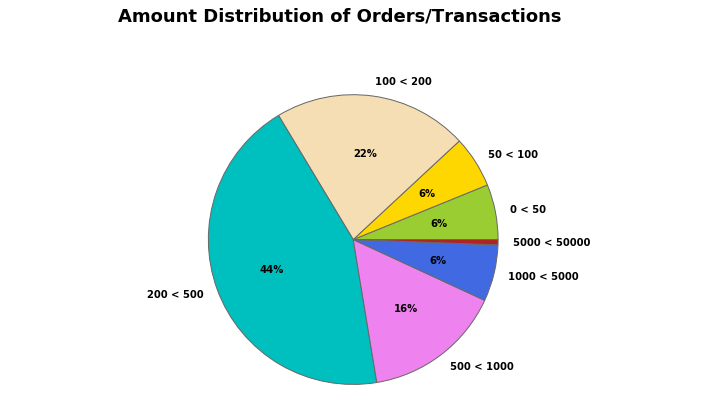

In [60]:
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{} < {}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Amount Distribution of Orders/Transactions", ha='center', fontsize = 18);

<h2>Understanding Product Categories</h2>
<br>
<b>What does the dataset tell us of its products?</b>
<ul>
    <li>Products are identified through the <code>StockCode</code> variable with unique ids.</li>
    <li><code>Description</code> column gives a short description of the products.</li>
</ul>
<br>
What we are going to do is to explore the content of the column <code>Description</code> in order to group the products into different categories.
<br>
<br>
This is going to be very excited and <i>tricky</i>. First we declared a variable that holds a <code>lambda</code> function called <code>is_noun()</code>, what it does is to check if from index 0 and 1 are considered <code>'NN'</code>, we are going to understand what this does and what its purpose is for our object of understanding the <code>Description</code> column.

In [61]:
is_noun = lambda pos: pos[:2] == 'NN'

The method <code>keywords_bags()</code> takes to parameters, <code>dataframe</code> and <code>column</code> with a default value of <code>Description</code>, <i>but what does it do?</i> It does some basic <b>Natural Language Preprocessing</b>.
<br>
<br>
<ol>
    <li>It starts with <code>nltk.download('punkt')</code>, for downloading necessary files for the stemmer.</li>
    <li>The it downloads <code>nltk.download('averaged_perceptron_tagger')</code> necessary for generalation.</li>
    <li>We assign a <i><a href=''>stemmer</a></i> a stemmers does the process of reducing inflection in 
        words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid 
        word in the language, we assign the algorithm for creating a stemmer for the english language.</li>
    <li>We create a dictionary called <code>keywords_roots</code>, here we will store the roots of words</li>
    <li>We create another dictionary called <code>keywords_select</code>, here we will store the association between the 
        root and the keyword.</li>
    <li>We create a dictionary named <code>count_keywords</code>, here we will store how many times a keyword appears.</li>
    <li>We create a list named <code>category_keys</code>, to store the keys of every keyword category.</li>
    <li>We create a variable named <code>icount</code>, this counter will help us on knowing how many times a keyword 
        appears.</li>
    <li>We enter to the first <code>for</code> loop, here we will iterate across the column <code>Description</code>:
        <ol>
            <li>We ask if the value <code><i>s</i></code> in the iteration  is null, with <code>isnull(s)</code>, if it is 
                null we continue with the next iteration, if it is not null we continue with the current iteration.</li>
            <li>We create a variable called <code>lines</code> that holds the result from lowercasing every value of 
                <code>s</code>, lowercasing is done with <code>s.lower()</code></li>
            <li>We create a variable <code>tokenized</code>, it holds a tokenized value from the every word in the string 
                <code>s</code>, tokenized a word  is the process of demarcating and possibly classifying sections of a 
                string of input characters.</li>
            <li>We create a variable that may become a <i>list</i>. Here we will assign the value or values returned from 
                iterating the values that are considered <b>nouns</b> in <code>tokenized</code> var, this is done with 
                asking if every value in <code>tokenized</code> is a noun with the function 
                <code>id_noun(<i>pos</i>)</code></li>
            <li>We enter into an inner <code>for</code> loop, here we will iterate across <code>nouns</code> <i>list</i>
                <ol>
                    <li>We again lowercase the string iteration <code>t</code> with <code>t.lower()</code> and then we 
                        create the var <code>root</code> and assign it the root of <code>t</code> with 
                        <code>stemmer.stem(t)</code>.</li>
                    <li>If <code>root</code> is found in <code>keywords_roots</code> we add <code>t</code> to the 
                        dictionary <code>keyword_roots</code> with the <i>keyword</i> <code>root</code>.</li>
                    <li>We increment by one the value for the <i>keyword</i> <code>root</code> in the dictionary 
                        <code>count_keywords</code>.</li>
                    <li><i>(else)</i>If <code>root</code> is not found in <code>keywords_roots</code>, we assign 
                        <code>t</code> to dictionary <code>keyword_roots</code> with the <i>keyword</i> <code>root</code>.
                    </li>
                    <li>We assign one as value for to the <i>keyword</i> <code>root</code> in the dictionary 
                        <code>count_keywords</code>.</li>
                </ol>
            </li>
        </ol>
    </li>
    <li>We enter into second <code>for</code> loop, we iterate across the <i>keys</i> of<code>keywords_roots</code>:
        <ol>
            <li>If the len of <code>keywords_roots[s]</code> is bigger than <b>1</b> we do the next:
                <ol>
                    <li>We create the var <code>min_length</code> and we asign it the value of <b>1000</b>.</li>
                    <li>We start another <code>for</code> loop, we iterate across the words in 
                        <code>keywords_roots[s]</code> with <code>k</code> as an <i>iterator object</i>, then:
                        <ol>
                            <li>If the len of <code>k</code> is smaller than <code>min_length</code> then we create a var 
                                call <code>category_key</code> we asign the value of <code>k</code> and to 
                                <code>min_length</code> we asign the value of the length of <code>k</code>.</li>
                        </ol>
                    </li>
                    <li>We append <code>category_key</code> to the dictionary <code>category_keys</code>.</li>
                    <li>We assign to <code>keywords_select[s]</code> the value of <code>category_keys</code>.</li>
                </ol>
            </li>
            <li><i>(else)</i> If the len of <code>keywords_roots[s]</code> is not bigger than <b>1</b> we do the next:
                <ol>
                    <li>We append to <code>category_keys</code> dictionary <code>list(keywords_roots[s])[0]</code>, which 
                        is the list of catergories keys.</li>
                    <li>We assign to dictionary keyword  <code>keywords_select[s]</code> 
                        <code>list(keywords_roots[s])[0]</code>, which is the list of catergories keys.</li>
                </ol>
            </li>
        </ol>
    </li>
    <li>We print the number of <i>keywords</i> of the column and the length of the categories found.</li>
    <li>Finally we returned <code>category_keys</code>, <code>keywords_roots</code>, <code>keywords_select</code> and 
        <code>count_keywords</code>.
</ol>

In [62]:
def keywords_bags(dataframe, column = 'Description'):
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the roots of words
    keywords_select = dict()  # associates the root and keyword
    count_keywords  = dict()
    category_keys   = []
    
    icount = 0
    for s in dataframe[column]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; root = stemmer.stem(t)
            if root in keywords_roots:                
                keywords_roots[root].add(t)
                count_keywords[root] += 1                
            else:
                keywords_roots[root] = {t}
                count_keywords[root] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    category_key = k ; min_length = len(k)            
            category_keys.append(category_key)
            keywords_select[s] = category_key
        else:
            category_keys.append(list(keywords_roots[s])[0])
            #keywords_select[s] = list(keywords_roots[s])[0]
            keywords_select[s] = list(keywords_roots[s])[1]
            
    print("Number of keywords in variable '{}': {}".format(column, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

<code>keywords_bags</code> does the next operations:
<ul>
    <li>Extract <i>nouns</i> or names, that are in the <code>Description</code> column.</li>
    <li>For each <i>nouns</i>:
        <ul>
            <li>Extracts the root of the word.</li>
            <li>Aggregates the set of <i>nouns</i> associated with its particular root.</li>
            <li>Counts the number of times that each root appears in the column <code>Description</code>.</li>
        </ul>
    </li>
    <li>When several words are listed for the same root,  the keyword associated with this root is the 
        shortest name (this systematically selects the singular when there are singular/plural variants).</li>
</ul>

Let's get the list of products:
<br>
We create a new <code>DataFrame</code> object, this new dataframe will have the unique values from the column <code>Description</code>, this values are obtained by <code>df.Description.<i>unique()</i></code>, once we have populated the new dataframe, we change the name of its only column by <code>Description</code>.

In [63]:
df_products = pd.DataFrame(df.Description.unique()).rename(columns = {0: 'Description'})

Now that we have created <code>df_products</code>, we can use the function <code>keywords_bags</code>, we pass the <code>df_products</code> as parameter, this function will return several dictionaries which we are going to hold them in <code>keywords</code>, <code>keywords_roots</code>, <code>keywords_select</code>, <code>count_keywords</code>.

In [64]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_bags(df_products)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kleye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kleye\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Number of keywords in variable 'Description': 1484


Great! We now have <b>1484</b> <i>keywords</i>.
Our function returned the next:
<ul>
    <li><code>keywords</code>: The list of extracted <i>keywords</i>.</li>
    <li><code>keywords_roots</code>: A dictionary where its keys are the <i>keywords roots</i> and the values are the lists 
        of words associated with these roots.</li>
    <li><code>keywords_select</code>: A dictionary that has the <i>keywords</i> that where selected for categories.</li>
    <li><code>count_keywords</code>: A dictionary with the numbers of times every word has been used.</li>
</ul>

Now we create a list <code>list_products</code> and we iterate with a <code>for</code> loop the items in <code>count_keyword</code> dictionary with <code>k</code> as iterator index and <code>v</code> as object, we then append to <code>list_products</code> with <code>[keywords_select[k], v</code>, this appends the selected keywords and its values.

In [65]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])

Then we sort this list

In [127]:
product_list = sorted(list_products, key = lambda x:x[1], reverse = True)

<h4>Plotting Most Common Words</h4>

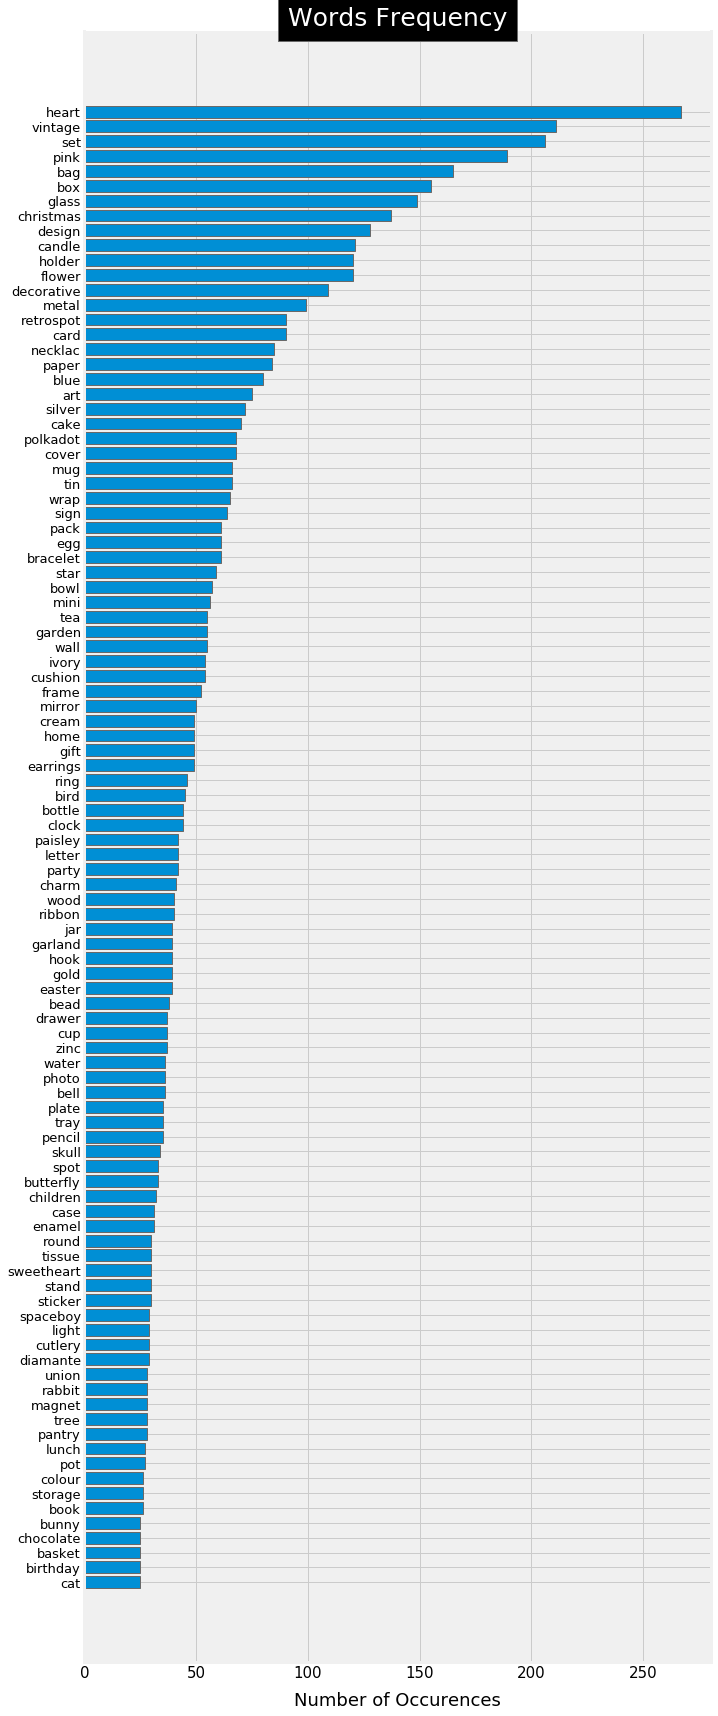

In [148]:
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(10, 30))
y_axis = [i[1] for i in product_list[:100]]
x_axis = [k for k,i in enumerate(product_list[:100])]
x_label = [i[0] for i in product_list[:100]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of Occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
plt.title("Words Frequency",bbox={'facecolor':'k', 'pad':10}, color='w', fontsize = 25)
plt.show()

In [135]:
product_list_DF = pd.DataFrame(product_list, columns=['Word', 'Number_Of_Frequency'])

In [136]:
product_list_DF.Word[:100]

0         heart
1       vintage
2           set
3          pink
4           bag
        ...    
95        bunny
96    chocolate
97       basket
98     birthday
99          cat
Name: Word, Length: 100, dtype: object

In [142]:
"""
fig = px.bar(product_list, x='Number Of Frequency', y='Word', text='Number Of Frequency', orientation='h')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

"""
fig = go.Figure(
    go.Bar(
        x=product_list_DF.Number_Of_Frequency[:100],
        y=product_list_DF.Word[:100],
        orientation='h',
        text='Word and its Frequency',
        base='relative'))
fig.update_layout(
    yaxis = dict(
        type='category',
        autorange='reversed'
    )
)
fig.show()

Great! We have a dynamic horizontal graph bar that shows the word and its frequency when the horizontal bar is hoovered.
<h4>Defining Product Categories</h4>
<br>
The <code>keywords</code> list contains 1484 <i>keywords</i> and the most frequent ones appear in more than 200 products. When examinating the content of this list, we can notice that some names are useless, do not carry information. Therefore we should discard these words from the analysis that follows and also let's consider only the words that appear more than <b>15</b> times.
<br>
<br>
Let's create the list <code>list_products</code>, then we iterate with a <code>for</code> loop the items in the dictionary <code>count_keywords</code>:
<ol>
    <li>We create the var <code>word</code>, we assign the value of the keyword of <code>keywords_select[k]</code>.</li>
    <li>If the word from <code>word</code> <i>var/list</i> is in this group 
        <code>['pink', 'blue', 'tag', 'green', 'orange']</code> then we do continue with the next iteration.</li>
    <li>If the length of <code>word</code> is smaller than <b>3</b> or samller than <b>15</b> then we
        do continue with the next iteration.</li>
    <li>If the characet <code>+</code> is in <code>word</code> or the characet <code>/</code> is in <code>word</code> 
        then we do continue with the next iteration.</li>
    <li>We append <code>word</code> and the <i>object iterator</i> to <code>list_products</code>.
</ol>

In [150]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 15: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])

We then sort the <code>list_products</code> in reverse, with a <code>lambda</code> function. After sorting the list we print how many words were kept.

In [152]:
list_products.sort(key = lambda x:x[1], reverse = True)
print('Number of words that were kept:', len(list_products))

Number of words that were kept: 168


We have the most common <i>keywords</i>, what we are going to do is to create <i>groups or clusters of words</i>, but first we are going to create a $X$ matrix, where $X_i,_j$ will take the value of $1$ if the <i>description</i> of the product $i$ contains the <i>word</i> $j$ and will take the value of $0$ if it does not contains the <i>word</i> $j$.

We create the list <code>list_descriptions</code> with the unique values from <code>Description</code> column, then we create a <code>DataFrame</code> object, that is going to be the matrix <code>X</code>, we are going to iterate with a <code>for</code> loop the list <code>list_descriptions</code> and for iterator <code>k</code> as index we set in <code>X.loc[:, key]</code> a list with the result from <i>mapping</i> the <code>lambda</code> function of <code>x:int(key.upper() in x)</code> in <code>list_descriptions</code>.

In [174]:
list_descriptions = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, frequency in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), list_descriptions))

Let's take a look at some random samples from the dataframe <code>X</code>

In [158]:
X.sample(5)

heart  vintage  set  bag  box  glass  christmas  design  candle  holder  \
310       0        0    0    0    0      0          0       0       0       0   
3246      1        0    0    0    0      0          0       0       0       0   
436       0        0    0    0    0      0          0       0       0       0   
125       1        0    0    0    0      0          0       0       0       0   
1793      0        0    0    0    0      0          0       0       0       0   

      ...  jigsaw  rack  coaster  money  cottage  incense  crystal  medium  \
310   ...       0     0        0      0        0        0        0       0   
3246  ...       0     0        0      0        0        0        0       0   
436   ...       0     0        0      0        0        0        0       0   
125   ...       0     0        0      0        0        0        0       0   
1793  ...       0     0        0      0        0        0        0       0   

      dish  image  
310      0      0  
3246     0      0  
436      0      0  
125      0      0  
1793     0      0  

[5 rows x 168 columns]

The $X$ matrix is for indicating the words that are contained in the description of the products using the <b><i>one-hot-encoding</i></b> principle. Now we are going introduce the price range results, therefore, let's add 6 extra columns to this matrix, where we indicate the price range of the products.
<br>
<br>
We create an array that works as range of threshold, <code>threshold</code> and a list <code>label_col</code>.

In [175]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []

Let's iterate the range of the lenght of <code>thereshold</code>:
<ol>
    <li>if the <i>iterator index</i> <code>i</code> is equal to <code>len(threshold)-1</code> then:
        <ul>
            <li>We assign to <code>col</code> <code>' > {}'.format(threshold[i])</code>, this is for indicating that is 
                comparing the last value in <code>threshold</code></li>
        </ul>
    </li>
    <li><i>(else)</i> We assign to <code>col</code> <code>'{} &lt; {}'.format(threshold[i],threshold[i+1])</code>,this is 
        for indicating that is the value from <code>threshold[i]</code> is smaller than the value in 
        <code>threshold[i+1]</code>.</li>
    <li>Then we append to <code>label_code</code> the value of <code>col</code>.</li>
    <li>We set in <code>X.loc[:, col]</code> the value of <code>0</code></li>
</ol>
In this <code>for</code> loop we create the new columns that are ranges comparisons.

In [176]:
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = ' > {}'.format(threshold[i])
    else:
        col = '{} < {}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

Let's take a random look at <code>X</code> 

In [177]:
X.sample(10)

heart  vintage  set  bag  box  glass  christmas  design  candle  holder  \
613       0        0    0    0    0      0          0       0       1       0   
140       0        0    0    0    0      0          0       0       0       0   
1572      0        0    0    0    0      0          0       0       0       0   
1505      0        0    0    0    0      0          0       0       0       0   
927       0        0    0    0    0      0          0       0       0       0   
1341      0        0    0    0    0      0          0       0       0       0   
1145      0        0    0    0    0      0          0       0       0       0   
1361      0        0    0    0    0      0          0       0       0       0   
1204      0        0    0    0    0      0          0       1       0       0   
992       0        0    0    0    0      0          0       0       0       0   

      ...  crystal  medium  dish  image  0 < 1  1 < 2  2 < 3  3 < 5  5 < 10  \
613   ...        0       0     0      0      0      0      0      0       0   
140   ...        0       0     0      0      0      0      0      0       0   
1572  ...        0       0     0      0      0      0      0      0       0   
1505  ...        0       0     0      0      0      0      0      0       0   
927   ...        0       0     0      0      0      0      0      0       0   
1341  ...        0       0     0      0      0      0      0      0       0   
1145  ...        0       0     0      0      0      0      0      0       0   
1361  ...        0       0     0      0      0      0      0      0       0   
1204  ...        0       0     0      0      0      0      0      0       0   
992   ...        0       0     0      0      0      0      0      0       0   

       > 10  
613       0  
140       0  
1572      0  
1505      0  
927       0  
1341      0  
1145      0  
1361      0  
1204      0  
992       0  

[10 rows x 174 columns]

It has 6 new columns ranges!
<br>
Let's go and interate across the list <code>list_descriptions</code>:
<ol>
    <li>We create a var called <code>prix</code> this var will hold the product the <b>mean</b> of <code>UnitPrice</code>
    only if the product is find.</li>
    <li>We assign to var <code>j</code> the value of <b>0</b></li>
    <li>
        We enter into a <code>while</code> loop and its conditios is <code>prix > threshold[j]</code>, this means that if 
        the value of <code>prix</code> is bigger than the value in <code>threshold[j]</code> enters the loops or stays 
        looping.</li>
        <ol>
            <li>We increment the value of <code>j</code> by <b>1</b>.</li>
            <li>If the value of <code>j</code> is equal to the length of <code>threshold</code> we break the loop.</li>
        </ol>
    </li>
    <li>We assign through <code>X.loc[i, label_col[j-1]]</code> the value of <b>1</b>, this means that in the position 
    row equals <code>i</code> and column <code>label_col[j-1]</code>, we put the value of <b>1</b>. We found a word in the descriptions!</li>
</ol>

In [180]:
for i, prod in enumerate(list_descriptions):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

We move to another <code>for</code> loop that iterates through the 
Next we choose the appropiate ranges, we check the number of products in different groups ranges

In [188]:
print("{:<8} {:<20}\n".format('Range', 'Number of Products'))
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = ' > {}'.format(threshold[i])
    else:
        col = '{} < {}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

Range    Number of Products  

0 < 1       964                 
1 < 2       1009                
2 < 3       673                 
3 < 5       606                 
5 < 10      470                 
 > 10       156                 


<h4>Creating Clusters of Products</h4>
<br>
We are going to group the products into different classes, as we have $X$ a binary encoded matrix the most suitable metric for calculating the distances and similarity is the <a href='https://en.wikipedia.org/wiki/Hamming_distance'>Hamming Distance Metric</a>, we are going to use the <code>KModes</code> algorithm, which is the most adequate choice for categorical data and in order to define (approximately) the number of clusters that best represents the data, we use the silhouette score.

In [204]:
from kmodes.kmodes import KModes

for n_clusters in range(3,10):
    kmodes = KModes(init='Huang', max_iter=100, n_clusters=n_clusters, n_init=30, n_jobs=-1, random_state=42)
    clusters = kmodes.fit_predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10894179126482142
For n_clusters = 4 The average silhouette_score is : 0.13577635589616008
For n_clusters = 5 The average silhouette_score is : 0.15526666330672245
For n_clusters = 6 The average silhouette_score is : 0.16273636932600374
For n_clusters = 7 The average silhouette_score is : 0.149980341135399
For n_clusters = 8 The average silhouette_score is : 0.1558094009010144
For n_clusters = 9 The average silhouette_score is : 0.12815985963469329


To understand how <code>KModes</code> works check this <a href='https://www.youtube.com/watch?v=b39_vipRkUo'>video link</a> and this <a herf='https://medium.com/@davidmasse8/unsupervised-learning-for-categorical-data-dd7e497033ae'>post</a>.
<br>
<br>To understand why we choose the <code>silhouette_score</code> check this <a href='https://towardsdatascience.com/10-tips-for-choosing-the-optimal-number-of-clusters-277e93d72d92'>post</a>

Cool! We have clustered the words! Let's choose to separate the dataset into 6 clusters. In order to ensure a good classification at every run of the notebook, we will iterate untill we obtain the best possible <code>silhouette score</code>, which is around 0.16

In [205]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.15:
    kmodes = KModes(init='Huang', max_iter=75, n_clusters=n_clusters, n_init=30, n_jobs=-1, random_state=42)
    clusters = kmodes.fit_predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print('For n_clusters = ', n_clusters, ' The average silhouette_score is : ', silhouette_avg)

For n_clusters =  5  The average silhouette_score is :  0.15526666330672245


<h4>Visualizing the Quality and Content of the Clusters</h4>
<br>
Let's first check the number of elements in every class.

In [206]:
pd.Series(clusters).value_counts()

0    1165
1     964
4     673
3     606
2     470
dtype: int64

Great! We know how many words are in every cluster.

<h4>Visualizing For Selection The Number of Clusters with Silhouette Analysis on KModes Clustering</h4>
<br>
The explanation of <b>Silhouette Analysis</b> and function <code>graph_component_silhouette()</code> are an adaptation from <a href='https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html'>scikit-learn</a> docs.
<br>
<br>
<b>What is Silhouette analysis?</b> 
<blockquote>
    Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot 
    displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a 
    way to assess parameters like number of clusters visually. This measure has a range of [-1, 1]
</blockquote>


<b>What do Silhouette Coefficients mean?</b>
<blockquote>
    Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the 
    neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two 
    neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.
</blockquote>

In [210]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

Let's get individual silouhette scores

In [211]:
sample_silhouette_values = silhouette_samples(X, clusters)

Execute the function <code>graph_component_silhouette()</code>.

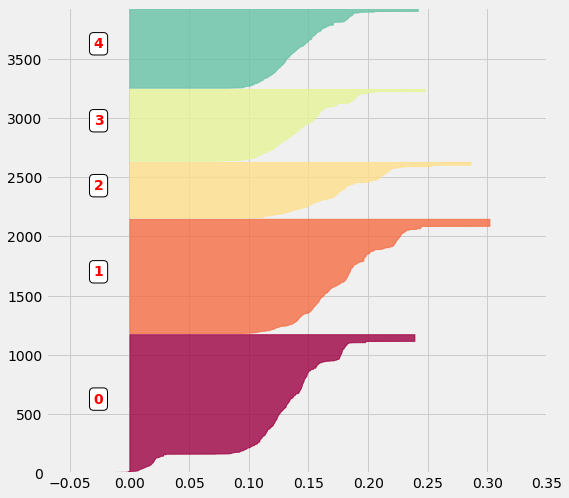

In [212]:
graph_component_silhouette(n_clusters, [-0.07, 0.35], len(X), sample_silhouette_values, clusters)

<h4>Understanding the Silhouette Graph</h4>
<br>
<b>From the official docs</b>
<blockquote>
    In this example the silhouette analysis is used to choose an optimal value for <code>n_clusters</code>. The 
    silhouette plot shows that <code>n_clusters</code> could be a bad pick for the given data due to the presence of 
    clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots.
    <br>
    <br>
    Also from the thickness of the silhouette plot the cluster size can be visualized.
</blockquote>

<h4>Visualizing the Content of the Clusters</h4>
<br>
This will be done with <b>Word Clouds!</b>. Let's have a look at the type of objects that each cluster represents by getting a global view of their contents, we must first determine which keywords are the most frequent in each of them.

In [223]:
list_d = pd.DataFrame(list_descriptions)
list_words = [word for (word, frequency) in list_products]

In [224]:
frequency = [dict() for _ in range(n_clusters)]

In [225]:
for i in range(n_clusters):
    list_cluster = list_d.loc[clusters == i]
    for word in list_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        frequency[i][word] = sum(list_cluster.loc[:, 0].str.contains(word.upper()))

In [226]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

In [231]:
def make_wordcloud(list_wf, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = list_wf[0:100]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))

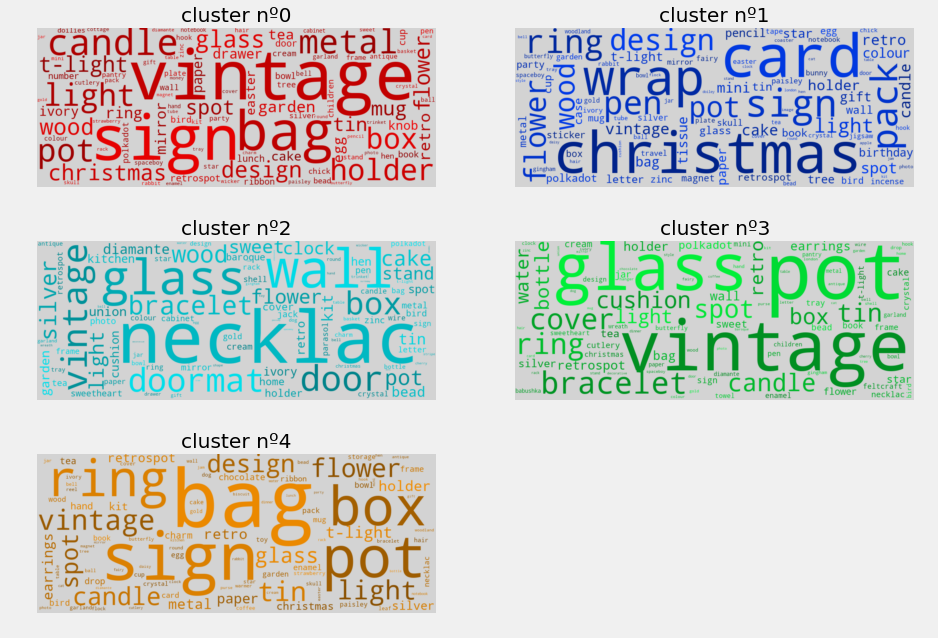

In [235]:
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_frequencies = frequency[i]

    tone = color[i] # define the color of the words
    list_word_frequency = []
    for key, value in list_cluster_frequencies.items():
        list_word_frequency.append([key, value])
    list_word_frequency.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(list_word_frequency, i+1)   

In [234]:
!git add . e-commerce_uk_retailer_machine_learning_analysis.ipynb
!git commit -m "Word Cloud Plotted But not Explained"
!git push origin master --force

The file will have its original line endings in your working directory


[master f3496c3] Word Cloud Plotted But not Explained
 1 file changed, 828 insertions(+), 1014 deletions(-)


To https://github.com/kleyersoma/E-Commerce_UK_Retailer_ML
   9fba0cd..f3496c3  master -> master


In [189]:
from kmodes.kmodes import KModes


KModes(cat_dissim=<function matching_dissim at 0x000001CD96EBAD08>, init='Cao',
       max_iter=100, n_clusters=8, n_init=1, n_jobs=1, random_state=None,
       verbose=0)